In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.signal import convolve2d

In [4]:
from scipy.optimize import fixed_point, root_scalar

In [5]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

In [603]:
from numba import jit

# Finite differences updates

In [5]:
L=np.array([[0,1,0], [1, -4,1], [0,1,0]])

In [6]:
L=np.array([[1/4,1/2,1/4], [1/2, -3,1/2], [1/4,1/2,1/4]])

In [7]:
def update_rho(rho, m, v, D, dt, dx):
    #rho[rho<1e-3]=0
    return(rho 
           - v*(dt/dx)*(np.roll(m, axis=1,shift=-1)-np.roll(m, axis=1,shift=1))/2
           + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap'))

In [8]:
def update_m(rho, m, v, D, beta, dt, dx):
    #rho[rho<1e-3]=0    
    return(m 
           - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2
           + D*(dt/(dx*dx))*convolve2d(m, L, mode='same', boundary='wrap')
           + 2*dt*(beta-1-1/rho)*m 
           #+ 2*dt*(beta-1-np.divide(1, rho, where=rho!=0, out=np.zeros_like(rho)))*m 
           - dt*beta*beta*(1-beta/3)*m*m*m/(rho*rho)
          )

In [868]:
def update_X(X, v, D, beta, r, dt, dx, ly):
    rho, m = X[:ly, :], X[ly:, :]   
    
    drho = rho - v*(dt/dx)*(np.roll(m, axis=1,shift=-1)-np.roll(m, axis=1,shift=1))/2 + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    dm = m - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2 + D*(dt/(dx*dx))*convolve2d(m, L, mode='same', boundary='wrap') + 2*dt*(beta-1-np.divide(r, rho, out=np.zeros_like(rho), where=rho!=0))*m- dt*beta*beta*(1-beta/3)*m*m*m/(rho*rho) 
       
    return(np.concatenate([drho, dm]))

# Asymptotic droplet profiles

In [673]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [1041]:
lx=1000#0
ly=250#0
ds=1
r=1

tmax=50
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2
rho0=1.5
print((beta-1-r/rho0))

0.33333333333333337


In [1042]:
D=1
rho=rho0*np.ones((ly,lx))


m=np.sqrt(2*rho*rho*(beta-1-r/rho)/(beta*beta*(1-beta/3)))
print(m)
h0=2
m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, m])

[[1.1 1.1 1.1 ... 1.1 1.1 1.1]
 [1.1 1.1 1.1 ... 1.1 1.1 1.1]
 [1.1 1.1 1.1 ... 1.1 1.1 1.1]
 ...
 [1.1 1.1 1.1 ... 1.1 1.1 1.1]
 [1.1 1.1 1.1 ... 1.1 1.1 1.1]
 [1.1 1.1 1.1 ... 1.1 1.1 1.1]]


In [1043]:
%%time
prof_rho=[]
prof_m=[]
prof_rho.append(rho.copy())
prof_m.append(m.copy())

clap=0
gap=10

for t in vec_t:
    X0=X.copy()
    
    X=update_X(X0, v, D, beta, r, dt, ds, ly)
    
    rho, m = X[:ly, :], X[ly:, :]  
    
    if(t>=clap):
        print(t)
        prof_rho.append(rho)
        prof_m.append(m)
        clap+=gap

0.0
10.0
20.0
30.0
40.0
CPU times: user 14.3 s, sys: 3.92 ms, total: 14.3 s
Wall time: 14.3 s


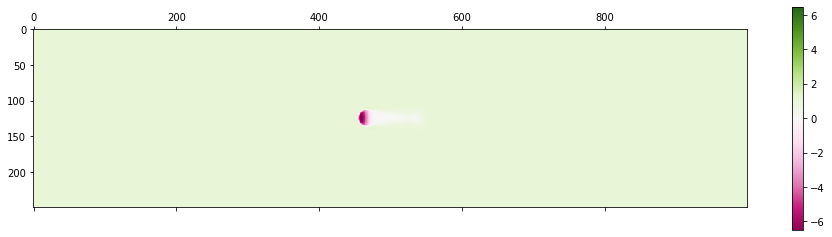

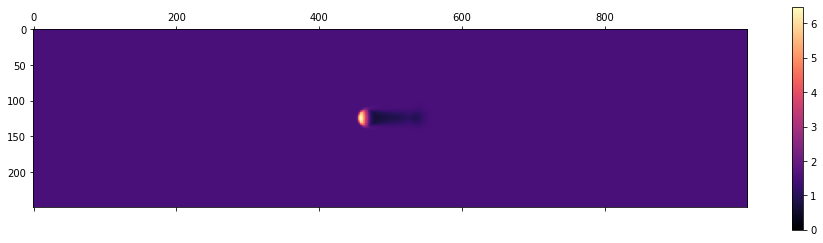

In [1045]:
t=4
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.matshow(rhop, cmap='magma', vmin=0, vmax=vmax)
plt.colorbar();


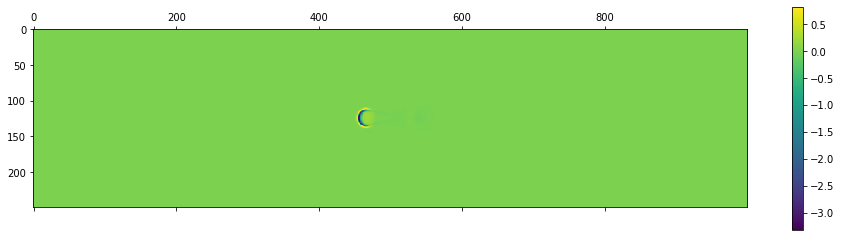

In [1050]:
plt.matshow(2*mp*(beta -1 -r/rhop) - (beta*beta*(1-beta/3))*(mp*mp*mp)/(rhop*rhop) )
plt.colorbar()

In [1051]:
2*mp*(beta -1 -r/rhop) - (beta*beta*(1-beta/3))*(mp*mp*mp)/(rhop*rhop)


array([[1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16],
       [1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16],
       [1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16],
       ...,
       [1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16],
       [1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16],
       [1.1e-16, 1.1e-16, 1.1e-16, ..., 1.1e-16, 1.1e-16, 1.1e-16]])

## Explore unstabilities

(100, 150)

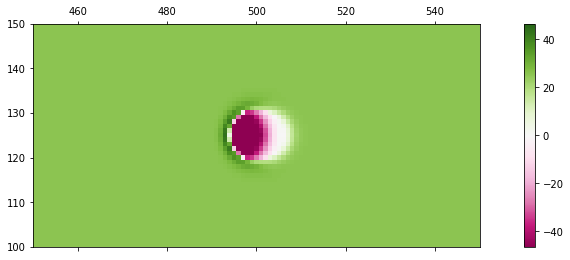

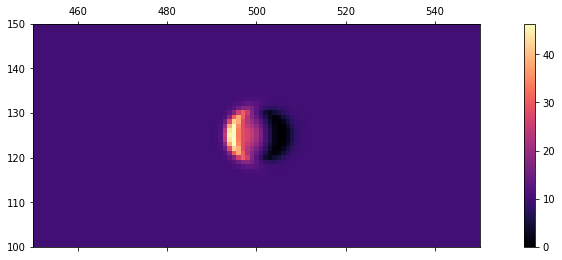

In [978]:
t=11
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.xlim(450,550)
plt.ylim(100,150)

plt.matshow(rhop, cmap='magma', vmin=0, vmax=vmax)
plt.colorbar();
plt.xlim(450,550)
plt.ylim(100,150)

### m gradient

In [929]:
dx=ds

(100, 150)

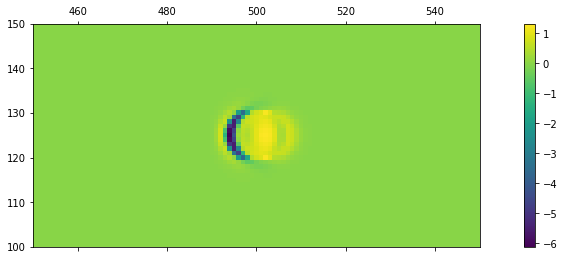

In [979]:
plt.matshow(v*(dt/dx)*(np.roll(mp, axis=1,shift=-1)-np.roll(mp, axis=1,shift=1))/2)
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

### rho gradient

(100, 150)

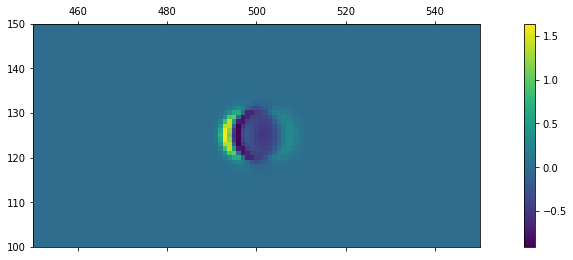

In [980]:
plt.matshow(v*(dt/dx)*(np.roll(rhop, axis=1,shift=-1)-np.roll(rhop, axis=1,shift=1))/2)
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

### m laplacian

(100, 150)

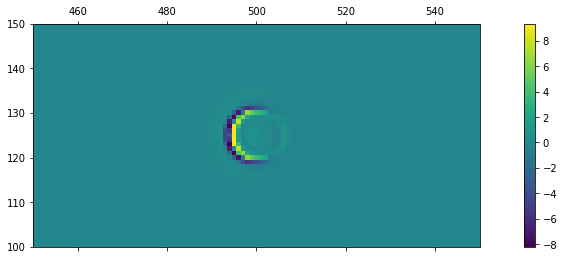

In [981]:
plt.matshow(D*(dt/(dx*dx))*convolve2d(mp, L, mode='same', boundary='wrap'))
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

### rho laplacian

(100, 150)

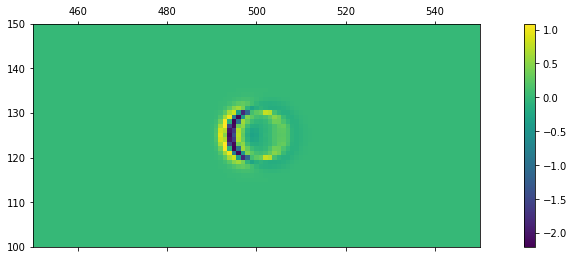

In [982]:
plt.matshow(D*(dt/(dx*dx))*convolve2d(rhop, L, mode='same', boundary='wrap'))
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

### propto m

(100, 150)

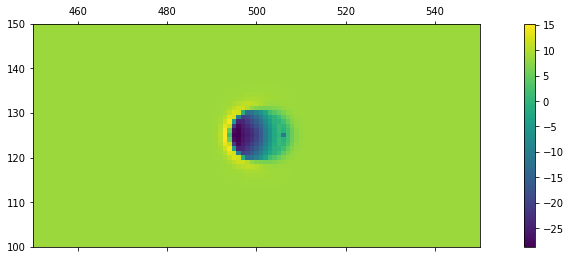

In [983]:
plt.matshow(2*dt*(beta-1-np.divide(r, rhop, out=np.zeros_like(rhop), where=rhop!=0))*mp)
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

### Non linear

(100, 150)

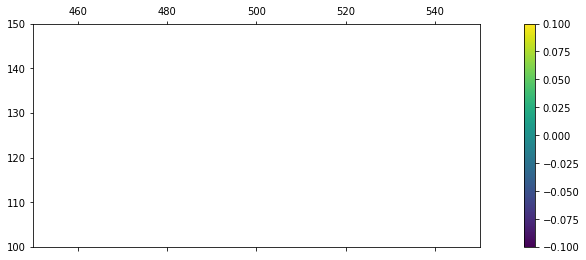

In [1027]:
t=10
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))
plt.matshow(dt*beta*beta*(1-beta/3)*mp*mp*mp/(rhop*rhop))
plt.colorbar()
plt.xlim(450,550)
plt.ylim(100,150)

(110, 140)

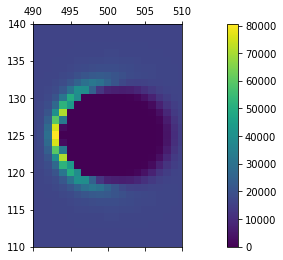

In [1011]:
plt.matshow(mp**3, vmin=-100)
plt.colorbar()
plt.xlim(490,510)
plt.ylim(110,140)

(110, 140)

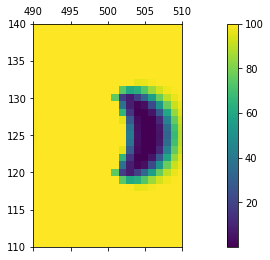

In [1012]:
plt.matshow(rhop**2, vmax=100)
plt.colorbar()
plt.xlim(490,510)
plt.ylim(110,140)

(110, 140)

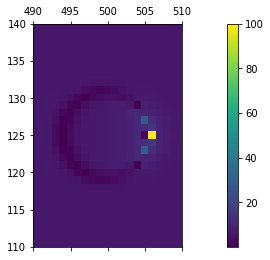

In [1014]:
plt.matshow((mp/rhop)**2, vmax=100)
plt.colorbar()
plt.xlim(490,510)
plt.ylim(110,140)

In [986]:
np.max((rhop))

46.395070206729066

## Save data

In [815]:
directory='PDEs_asympt_prof_lx%s_ly%s_rho%s_v%s_D%s_beta%s_r1'%(str(lx), str(ly), str(rho0), str(v), str(D), str(beta))
directory

'PDEs_asympt_prof_lx10000_ly2500_rho1_v1_D1_beta2.5_r1'

In [820]:
!mkdir asympt_droplet_shape_2D/PDEs_asympt_prof_lx10000_ly2500_rho1_v1_D1_beta2.5_r1

In [822]:


tk=0
for m in prof_m:
    pd.DataFrame(m, columns=np.arange(lx).astype(str)).to_parquet('asympt_droplet_shape_2D/'+directory+'/asympt_mag_prof_lx%s_ly%s_rho%s_v%s_D%s_beta%s_r1_t%s.parquet'%(str(lx), str(ly), str(rho0), str(v), str(D), str(beta), str(100*tk)))
    tk+=1

In [824]:
prof_rho[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [825]:
for t in [5, 10, 15, 20, 25]:
    m=prof_rho[t]
    pd.DataFrame(m, columns=np.arange(lx).astype(str)).to_parquet('asympt_droplet_shape_2D/'+directory+'/asympt_density_prof_lx%s_ly%s_rho%s_v%s_D%s_beta%s_r1_t%s.parquet'%(str(lx), str(ly), str(rho0), str(v), str(D), str(beta), str(100*t)))


## Plot stuf

/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


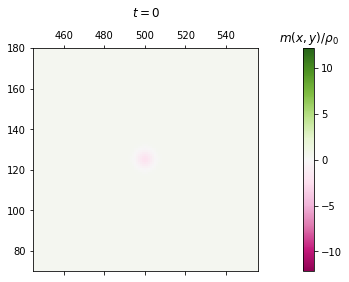

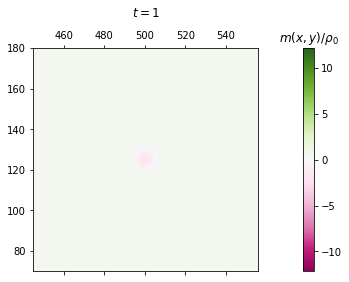

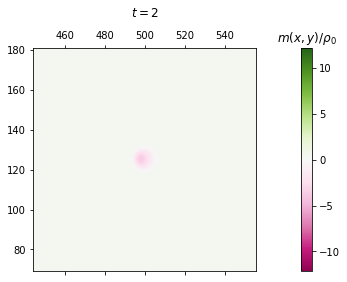

TypeError: Input z must be at least a 2x2 array.

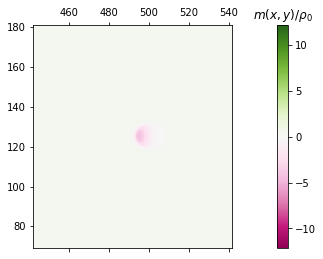

In [879]:
V=np.max(np.max(np.abs(prof_m[6])))/rho0
k=0
for m in prof_m:
    xmin=np.where((np.roll(m[np.int64(ly/2),:],1)>0)&(m[np.int64(ly/2),:]<0))[0][0]
    xmax=np.where(m[np.int64(ly/2),xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=np.int64(ly/2)#np.argmax(np.sum(m<0, axis=0))
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)

    l=plt.matshow(m, cmap='PiYG', vmin=-V, vmax=V)
    cbar=plt.colorbar(l)
    cbar.ax.set_title(r'$m(x,y)/\rho_0$', rotation=0)
    offset=50
    plt.xlim(xmin-offset, xmax+offset)
    plt.ylim(ymin-offset, ymax+offset)
    
    xlist = np.arange(xmin, xmax)
    ylist = np.arange(ymin, ymax)
    X, Y = np.meshgrid(xlist, ylist)
    Z = m[ymin:ymax,xmin:xmax]
    cp = plt.contour(X, Y, Z, levels=np.array([-25, -50,-150,-250][::-1])/rho0, colors=['k'])
    plt.title(r'$t=%d$'%(gap*k), pad=20)
    k+=1
    plt.show()
    



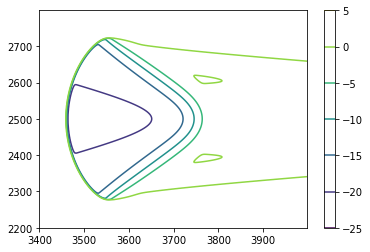

In [150]:
xlist = np.arange(xmin, xmax)
ylist = np.arange(ymin, ymax)
X, Y = np.meshgrid(xlist, ylist)
Z = m1[ymin:ymax,xmin:xmax]
cp = plt.contour(X, Y, Z, levels=5)
plt.colorbar(cp)


In [136]:
m1=prof_m[3].copy()
m2=prof_m[5].copy()
m3=prof_m[7].copy()

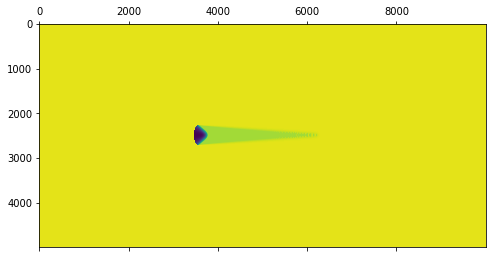

In [147]:
plt.matshow(m1)

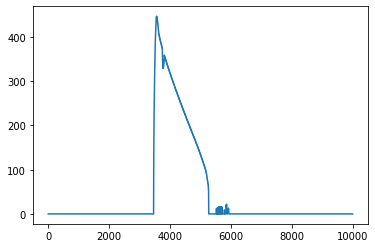

In [153]:
plt.plot(np.sum(m1<0, axis=0))

In [223]:
Lmax=np.max(np.sum(m1<0, axis=0))
yM=np.argmax(np.sum(m1<0, axis=0))
ymin=yM-np.int64(0.5*Lmax)
ymax=yM+np.int64(0.5*Lmax)


In [142]:
np.unravel_index(np.argmin(m1, axis=None), m1.shape)

(2500, 3472)

In [155]:
np.unravel_index(np.argmax(m1, axis=None), m1.shape)

(2725, 3558)

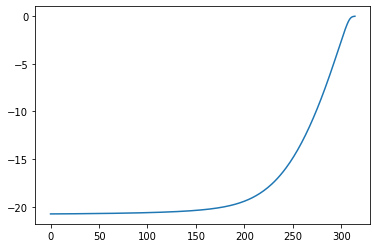

In [149]:
plt.plot(m1[2500,3472:3472+315])


In [87]:
np.min(rhop[2500,:])

0.7050463624373416

In [204]:
m0=np.sqrt(2*rho0*rho0*(beta-1-1/rho0)/(beta*beta*(1-beta/3)))

In [258]:
m=m1

In [259]:
xmin=np.where((np.roll(m[2500,:],1)>0)&(m[2500,:]<0))[0][0]
xmax=np.where(m[2500,xmin:]>-1e-1)[0][0]+xmin
print(xmin, xmax)

3460 3783


In [260]:
Lmax=np.max(np.sum(m<0, axis=0))
yM=2500#np.argmax(np.sum(m<0, axis=0))
ymin=yM-np.int64(0.5*Lmax)
ymax=yM+np.int64(0.5*Lmax)
print(ymin, ymax)

2277 2723


/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


IndexError: index 0 is out of bounds for axis 0 with size 0

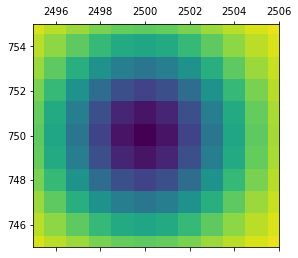

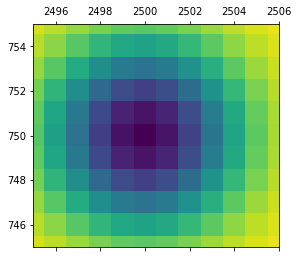

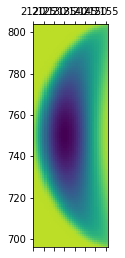

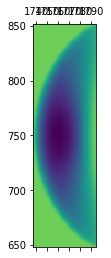

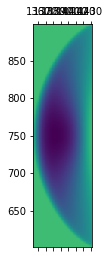

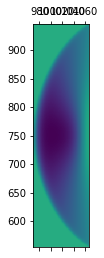

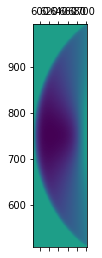

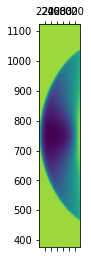

In [618]:
for m in prof_m:
    xmin=np.where((np.roll(m[np.int64(ly/2),:],1)>0)&(m[np.int64(ly/2),:]<0))[0][0]
    xmax=np.where(m[np.int64(ly/2),xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=np.int64(ly/2)#np.argmax(np.sum(m<0, axis=0))
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)
    
    plt.matshow(m)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

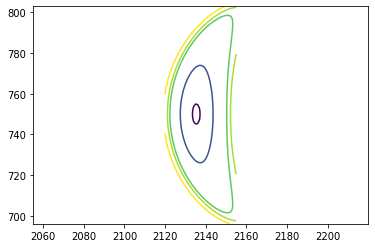

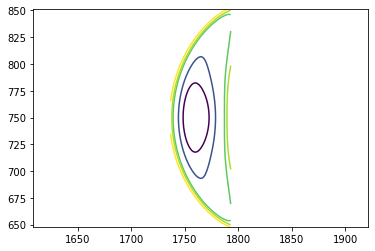

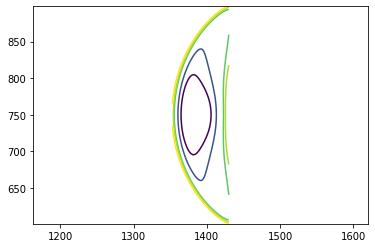

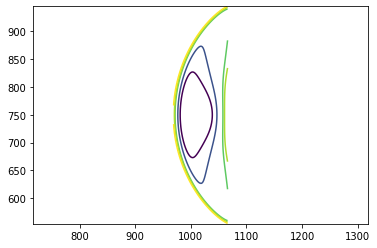

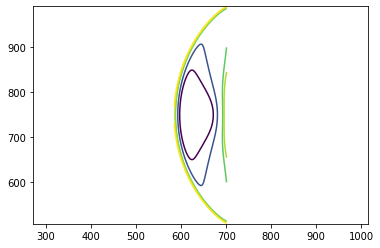

/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


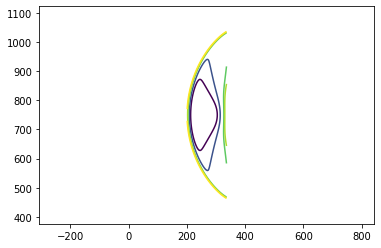

IndexError: index 0 is out of bounds for axis 0 with size 0

In [625]:
for m in prof_m[2:-3]:
    xmin=np.where((np.roll(m[np.int64(ly/2),:],1)>0)&(m[np.int64(ly/2),:]<0))[0][0]
    xmax=np.where(m[np.int64(ly/2),xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=np.int64(ly/2)#np.argmax(np.sum(m<0, axis=0))
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)

    xlist = np.arange(xmin, xmax)
    ylist = np.arange(ymin, ymax)
    X, Y = np.meshgrid(xlist, ylist)
    Z = m[ymin:ymax,xmin:xmax]
    cp = plt.contour(X, Y, Z, levels=[-40, -30, -10, -5, 0])
    plt.axis('equal')
    plt.show()
#plt.colorbar(cp)


tk=0
for m in prof_m:
    pd.DataFrame(m, columns=np.arange(lx).astype(str)).to_parquet('asympt_mag_prof_lx%s_ly%s_rho%s_v%s_D%s_beta%s_t%s.dat'%(str(lx), str(ly), str(rho0), str(v), str(D), str(beta), str(500*tk)))
    tk+=1

/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linestyle'


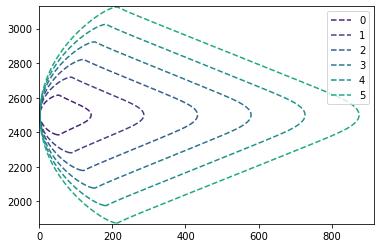

In [353]:
c=1
k=1
cp=[]
for m in prof_m[2:-3]:
    xmin=np.where((np.roll(m[2500,:],1)>0)&(m[2500,:]<0))[0][0]
    xmax=np.where(m[2500,xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=2500
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)

    xlist = np.arange(0, xmax-xmin)
    ylist = np.arange(ymin, ymax)
    X, Y = np.meshgrid(xlist, ylist)
    Z = m[ymin:ymax,xmin:xmax]
    cp.append(plt.contour(X, Y, Z, levels=[-10], colors=[plt.get_cmap('viridis')(k/10)], linestyle='-'))

    k+=1
    

plt.legend([cp[k].legend_elements()[0][0] for k in range(6)], np.arange(6))
    

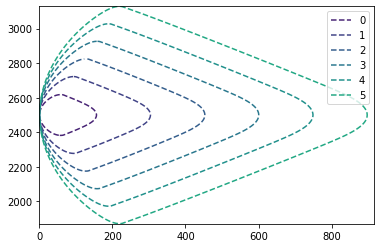

In [357]:
c=1
k=1
cp=[]
for m in prof_m[2:-3]:
    xmin=np.where((np.roll(m[2500,:],1)>0)&(m[2500,:]<0))[0][0]
    xmax=np.where(m[2500,xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=2500
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)

    xlist = np.arange(0, xmax-xmin)
    ylist = np.arange(ymin, ymax)
    X, Y = np.meshgrid(xlist, ylist)
    Z = m[ymin:ymax,xmin:xmax]
    cp.append(plt.contour(X, Y, Z, levels=[-5], colors=[plt.get_cmap('viridis')(k/10)]))

    k+=1
    

plt.legend([cp[k].legend_elements()[0][0] for k in range(6)], np.arange(6))
    

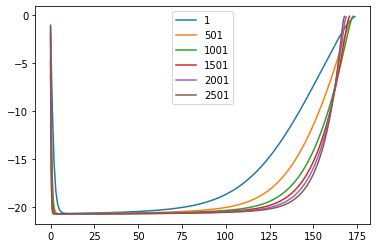

In [432]:
c=0.3
k=1
for m in prof_m[2:-3]:
    xmin=np.where((np.roll(m[2500,:],1)>0)&(m[2500,:]<0))[0][0]
    xmax=np.where(m[2500,xmin:]>-1e-1)[0][0]+xmin
    
    Lmax=np.max(np.sum(m<0, axis=0))
    yM=2500
    ymin=yM-np.int64(0.5*Lmax)
    ymax=yM+np.int64(0.5*Lmax)

    absx=np.linspace(0,(xmax-xmin)- k*c, xmax-xmin)
    plt.plot(absx, m[2500,xmin:xmax], label=k)
    k+=500
    
plt.legend()

(300, 1500)

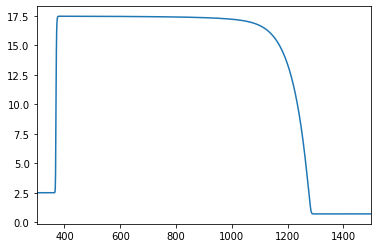

In [68]:
plt.plot(rhop[2500,:])
plt.xlim(300,1500)

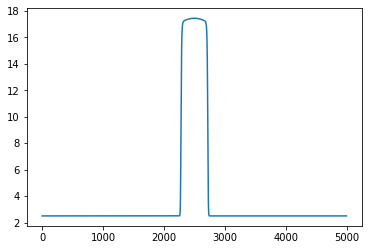

In [63]:
plt.plot(rhop[:,390], np.arange())

# Phase diagram $(D, \rho_0)$

In [9]:
data_liq=pd.read_csv('D_rhol_ml.dat')
data_liq

,Unnamed: 0,D,rhol,ml
0,0,0.500000,3.631232,3.785692
1,1,0.555556,3.268990,3.335536
2,2,0.611111,3.008137,3.010155
3,3,0.666667,2.811184,2.763569
4,4,0.722222,2.656983,2.569792
5,5,0.777778,2.532751,2.413109
6,6,0.833333,2.430336,2.283482
7,7,0.888889,2.344303,2.174207
8,8,0.944444,2.270889,2.080640
9,9,1.000000,2.207406,1.999462


In [10]:
list_D=data_liq.D.values
rhol= data_liq.rhol
ml=data_liq.ml

In [19]:
def liq_th(beta, v, D):
    r=1
    phig=r/(beta-1)
    alpha=beta*beta*(1-beta/3)
    c=v*(1+(8*r*r*D)/(3*alpha*v*v*phig*phig))**(1/4)
    mlth=4*r*v/(3*alpha*c)
    rholth=phig - 4*r*v*v/(9*alpha*c*c) + v*mlth/c
    return([rholth, mlth])

In [20]:
rholth, mlth =  liq_th(beta=2, v=1, D=list_D)

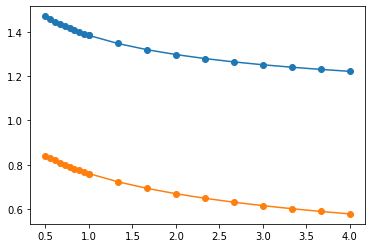

In [139]:

plt.plot(list_D, rholth, 'o-')
plt.plot(list_D, mlth, 'o-')

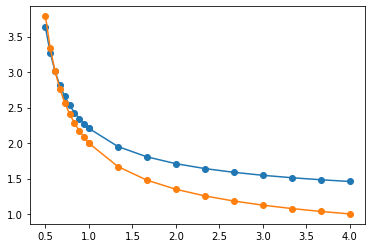

In [8]:
plt.plot(list_D, rhol, 'o-')
plt.plot(list_D, ml, 'o-')

Text(0, 0.5, '$D$')

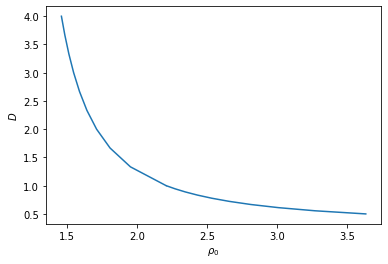

In [9]:
plt.plot(rhol, list_D, '-')
plt.xlabel(r'$\rho_0$')
plt.ylabel(r'$D$')
#plt.plot(list_D, ml, 'o-')

# Introduce Gaussian fluctuation in the liquid phase

In [10]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [73]:
lx=1000
ly=500
ds=1

tmax=10
dt=0.05
vec_t=np.arange(0,tmax,dt)

v=1
beta=2
rho0=2.5
print((beta-1-1/rho0))

0.6


In [74]:
D=4
rho=rho0*np.ones((ly,lx))


m=np.sqrt(2*rho*rho*(beta-1-1/rho)/(beta*beta*(1-beta/3)))
h0=10
m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, m])

In [75]:
D=4
rho=rho0*np.ones((ly,lx))


m=np.sqrt(2*rho*rho*(beta-1-1/rho)/(beta*beta*(1-beta/3)))
h0=10
m[240:260,490:510]-=3*m[0,0]
rho[240:260,490:510]+=rho[0,0]

X=np.concatenate([rho, m])

In [76]:
prof_rho=[]
prof_m=[]
prof_rho.append(rho.copy())
prof_m.append(m.copy())

for t in vec_t:
    X0=X.copy()
    
    X=update_X(X0, v, D, beta, dt, ds, ly)
    
    rho, m = X[:ly, :], X[ly:, :]  
    prof_rho.append(rho)
    prof_m.append(m)

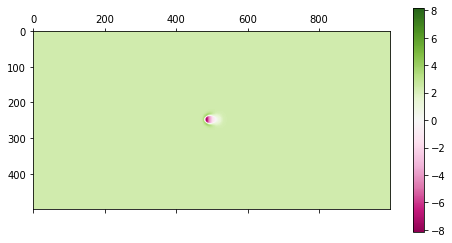

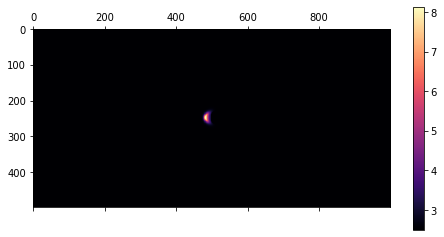

In [81]:
t=-1
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.matshow(rhop, cmap='magma', vmin=rho0, vmax=vmax)
plt.colorbar();


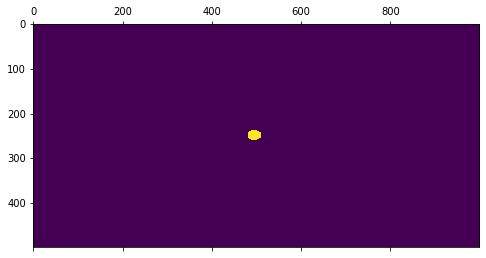

In [83]:
t=-1
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp<0)#, vmin=-vmax, vmax=vmax)



In [54]:
prof_m[t].shape

(200, 600)

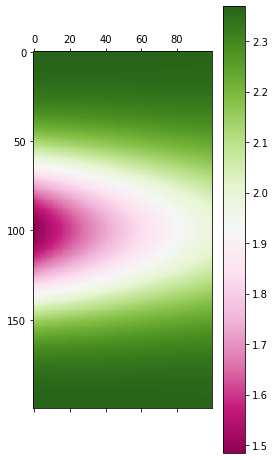

In [56]:
t=4000
mp=prof_m[t].copy()[:,400:500]
rhop=prof_rho[t].copy()
#vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG')#, vmin=-vmax, vmax=vmax)
plt.colorbar()


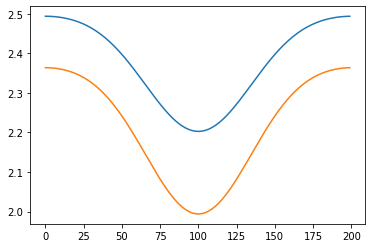

In [45]:
plt.plot(rhop[:,500])
plt.plot(mp[:,500])

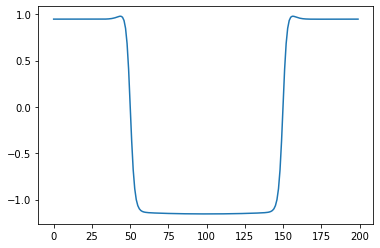

In [43]:
plt.plot(mp[:,590]/rhop[:,590])

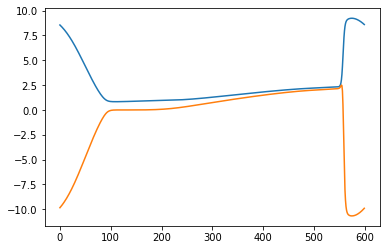

In [44]:
plt.plot(rhop[100,:])
plt.plot(mp[100,:])

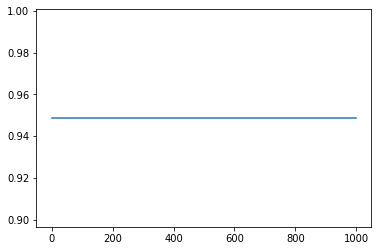

In [84]:
plt.plot(mp[100,:]/rhop[100,:])


(0, 600)

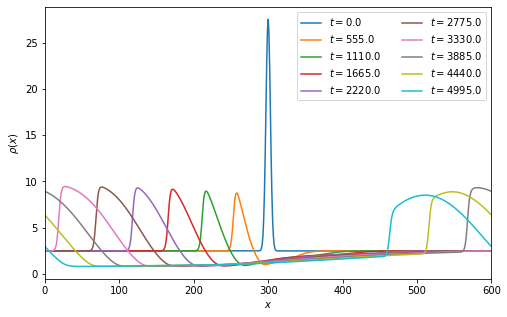

In [62]:
plt.figure(figsize=(8,5))
T=5000
for t in np.arange(0, T, np.int64(T/9)):
    plt.plot(prof_rho[t][100], label=r'$t=%.1f$'%t)

plt.legend(ncol=2)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')

plt.xlim(0,600)

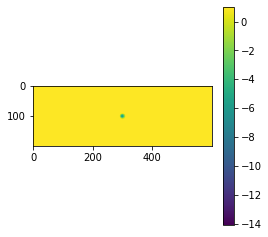

In [260]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(4, 4))

frame = 0

im = plt.imshow(prof_m[frame])
plt.colorbar()

def update(*args):
    global frame
    #print(frame)

    im.set_array(prof_m[frame])

    frame += 10
    frame %= len(prof_m)

    return im,

ani = animation.FuncAnimation(fig, update, len(prof_m))
writer = animation.ImageMagickFileWriter(fps=20)
ani.save('movie.gif', writer=writer) 

# Minimal Gaussian fluctuation to reverse the liquid phase

In [25]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [146]:
lx=600
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [573]:
nD=0
D=list_D[nD]
print('D =', D)
D=2

rho=2.5*np.ones((ly,lx)) #rhol[nD]*np.ones((ly,lx))
m=np.sqrt(2*rho*rho*(beta-1-1/rho)/(beta*beta*(1-beta/3))) #ml[nD]*np.ones((ly,lx))

h0=5
m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, m])

D = 0.5


In [574]:
prof_rho=[]
prof_m=[]
prof_rho.append(rho.copy())
prof_m.append(m.copy())

frac=np.sum(m<0)/(lx*ly)

while((frac>0) and (frac<0.1)):
    X0=X.copy()
    
    X=update_X(X0, v, D, beta, dt, ds, ly)
    
    rho, m = X[:ly, :], X[ly:, :]  
    frac=np.sum(m<0)/(lx*ly)

    prof_rho.append(rho)
    prof_m.append(m)

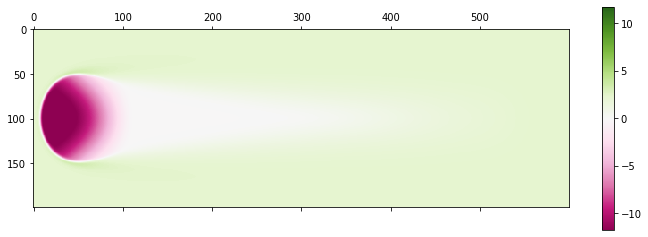

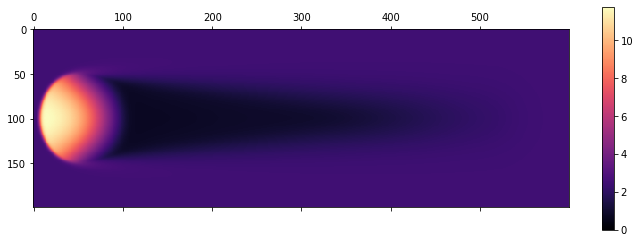

In [575]:
t=-1
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.matshow(rhop, cmap='magma', vmin=0, vmax=vmax)
plt.colorbar();


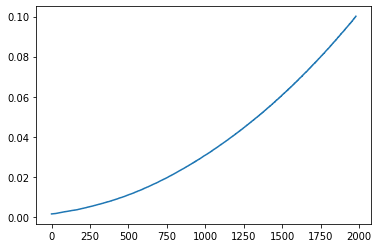

In [206]:
plt.plot([np.sum(p<0)/(lx*ly) for p in prof_m])

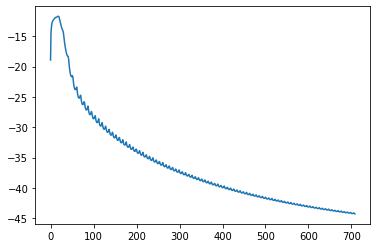

In [198]:
plt.plot([np.min(p[np.int64(ly/2),:]) for p in prof_m], '-')

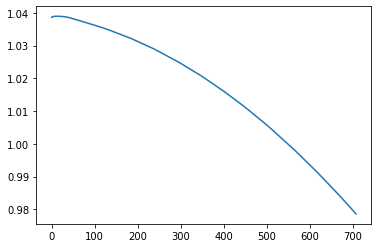

In [199]:
mag=np.array([np.sum(p) for p in prof_m])/np.sum(prof_rho[0])
plt.plot(mag)

In [356]:
def criterion_destab(h0, v, D, beta, rho0l, m0l, lx, ly):
    rho=rho0l*np.ones((ly,lx))
    m=m0l*np.ones((ly,lx))

    m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
    rho+=1*rho[0,0]*gaussianFluctH(lx, ly, h0)

    X=np.concatenate([rho, m])
    
    frac=np.sum(m<0)/(lx*ly)

    while((frac>0) and (frac<0.1)):
        X0=X.copy()

        X=update_X(X0, v, D, beta, dt, ds, ly)

        rho, m = X[:ly, :], X[ly:, :]  
        frac=np.sum(m<0)/(lx*ly)

    rho, m = X[:ly, :], X[ly:, :]  
    return(np.min(m[np.int64(ly/2),:]))

In [188]:
nD=3
criterion_destab(h0=10, v=1, D=list_D[nD], beta=2, rho0l=rhol[nD], m0l=ml[nD], lx=lx, ly=ly)

-28.499872159049183

In [191]:
nD=3
criterion_destab(h0=0.1, v=1, D=list_D[nD], beta=2, rho0l=rhol[nD], m0l=ml[nD], lx=lx, ly=ly)

1.9344985702188868

In [213]:
h0_crit=[]
for nD in range(len(list_D)):
    print(list_D[nD])
    h0_crit.append(root_scalar(criterion_destab, args=(1, list_D[nD], 2, rhol[nD], ml[nD], lx, ly), method='bisect', bracket=[0.01, 10]))

0.5
0.5555555555555556
0.6111111111111112
0.6666666666666667
0.7222222222222222
0.7777777777777778
0.8333333333333334
0.8888888888888888
0.9444444444444444
1.0
1.0
1.3333333333333333
1.6666666666666663
2.0
2.333333333333333
2.6666666666666665
3.0
3.333333333333333
3.6666666666666665
4.0


Text(0, 0.5, 'Critical fluctuation size')

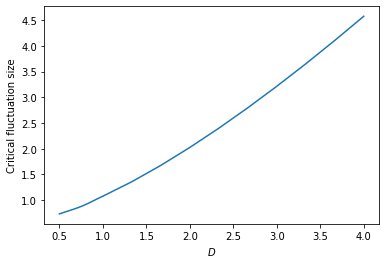

In [238]:
plt.plot(list_D, [h.root for h in h0_crit], '-')
#plt.plot(list_D, rhol, '-')

plt.xlabel(r'$D$')
plt.ylabel('Critical fluctuation size')

## Varying $\beta$

In [358]:
h0=10
v=1
D=1
beta=2
rho0=3
m0=np.sqrt(2*rho0*rho0*(beta-1-1/rho0)/(beta*beta*(1-beta/3)))

criterion_destab(h0=10, v=1, D=1, beta=2, rho0l=rho0, m0l=m0, lx=lx, ly=ly)

-24.14951828306416

In [359]:
criterion_destab(h0=10, v=1, D=1, beta=1.5, rho0l=rho0, m0l=m0, lx=lx, ly=ly)

-9.352210803143935

In [360]:
criterion_destab(h0=10, v=1, D=1, beta=1.3, rho0l=rho0, m0l=m0, lx=lx, ly=ly)

-2.2694171197971253

In [ ]:
h0_crit_beta=[]
list_beta=np.linspace(1.1,2.5,15)

v=1
D=1
rho0=20
lx=300
ly=100

for beta in list_beta:
    print(beta)
    m0=np.sqrt(2*rho0*rho0*(beta-1-1/rho0)/(beta*beta*(1-beta/3)))
    h0_crit_beta.append(root_scalar(criterion_destab, args=(v, D, beta, rho0, m0, lx, ly), method='bisect', bracket=[0.01, 10]))

1.1
1.2000000000000002


Text(0, 0.5, 'Critical fluctuation size')

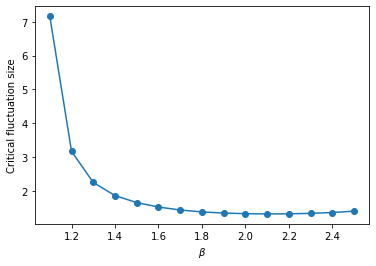

In [421]:
plt.plot(list_beta, [h.root for h in h0_crit_beta], 'o-')

plt.xlabel(r'$\beta$')
plt.ylabel('Critical fluctuation size')

## How far from the coexistence phase ?

In [578]:
h0_crit_coex=[]
for rho0 in np.linspace(2, 5, 10):
    m0=np.sqrt(2*rho0*rho0*(beta-1-1/rho0)/(beta*beta*(1-beta/3)))
    h0_crit_coex.append(root_scalar(criterion_destab, args=(1, list_D[nD], 2, rho0, m0, lx, ly), method='bisect', bracket=[0.01, 10]))

Text(0, 0.5, 'Critical fluctuation size')

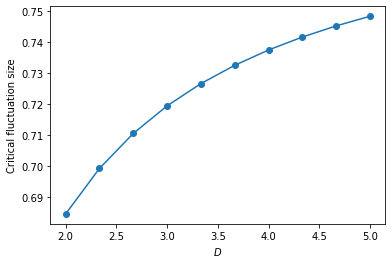

In [580]:
plt.plot(np.linspace(2, 5, 10), [h.root for h in h0_crit_coex], 'o-')
#plt.plot(list_D, rhol, '-')

plt.xlabel(r'$D$')
plt.ylabel('Critical fluctuation size')

# $\vec{m}$

## Basic equations

In [30]:
def update_X_vect(X, v, D, beta, dt, dx, ly):
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]   
    
    drho = rho\
    - v*(dt/dx)*(np.roll(my, axis=0,shift=-1)-np.roll(my, axis=0,shift=1))/2\
    - v*(dt/dx)*(np.roll(mx, axis=1,shift=-1)-np.roll(mx, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    norm_m=np.sqrt(mx*mx+my*my)
    
    dmx = mx\
    - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(mx, L, mode='same', boundary='wrap')\
    + 2*dt*(beta-1-1/rho)*mx \
    - dt*beta*beta*(1-beta/3)*mx*norm_m*norm_m/(rho*rho) 
       
    dmy = my \
    - v*(dt/dx)*(np.roll(rho, axis=0,shift=-1)-np.roll(rho, axis=0,shift=1))/2 \
    + D*(dt/(dx*dx))*convolve2d(my, L, mode='same', boundary='wrap') \
    + 2*dt*(beta-1-1/rho)*my\
    - dt*beta*beta*(1-beta/3)*my*norm_m*norm_m/(rho*rho) 

    return(np.concatenate([drho, dmx, dmy]))

In [31]:
# INITIAL CONDITION : blob of particles in disordered gas
rhof=np.ones((ly,lx))
mxf=np.zeros((ly,lx))
myf=np.zeros((ly,lx))


r0=1.
rhof[:, :]+=r0*np.exp(-((np.arange(lx)-(lx/2))/50)**2)
mxf[:, :]=np.sqrt(2*rhof*rhof*(beta-1-1/rhof)/(beta*beta*(1-beta/3)))
X=np.concatenate([rhof, mxf, myf])

In [32]:
lx=400
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [33]:
mxl_vec=np.loadtxt('mxl_vec_m.dat')
rhol_vec=np.loadtxt('rho_vec_m.dat')

In [34]:
# INITIAL CONDITION : fluctuation in liq phase
nD=-1
D=list_D[nD]
print('D =', D)

rho=rhol_vec[nD]*np.ones((ly,lx))
mx=mxl_vec[nD]*np.ones((ly,lx))
#my=myl_vec[nD]*np.ones((ly,lx))
my=np.zeros((ly,lx))


h0=800
mx-=3*mx[0,0]*gaussianFluctH(lx, ly, h0)
#my-=3*my[0,0]*gaussianFluctH(lx, ly, h0)

rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, mx, my])

D = 4.0


In [35]:
prof_rho=[]
prof_mx=[]
prof_my=[]

rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]
prof_rho.append(rho.copy())
prof_mx.append(mx.copy())
prof_my.append(my.copy())


for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [352]:
# LAUNCH TO RESUME SIMU
for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

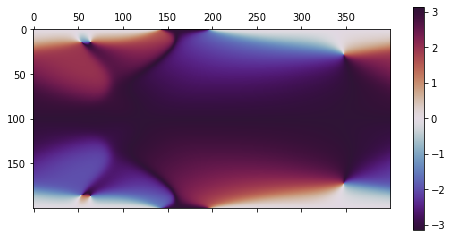

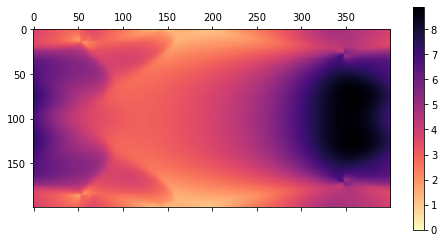

In [173]:
t=-1
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()

rhop=prof_rho[t].copy()
vmax=np.max(rhop)

plt.matshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
plt.colorbar()

plt.matshow(rhop, cmap='magma_r', vmin=0, vmax=vmax)
plt.colorbar();


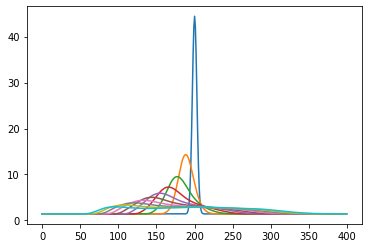

In [40]:
for t in np.arange(0, np.int64(tmax/dt),100):
    plt.plot(np.mean(prof_rho[t],0))

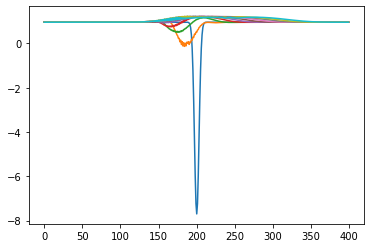

In [551]:
for t in np.arange(0, np.int64(tmax/dt),100):
    plt.plot(np.mean(prof_mx[t],0))

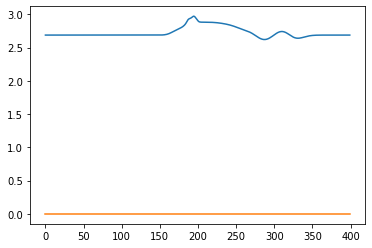

In [506]:
plt.plot(np.mean(prof_rho[t],0))
plt.plot(np.mean(np.arctan(myp, mxp),0))

Traceback (most recent call last):
  File "/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/users/invites/benvegnen/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1755, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-36-8968f24d18cd>", line 19, in update
    img.set_array(prof_rho[frame])
IndexError: list index out of range


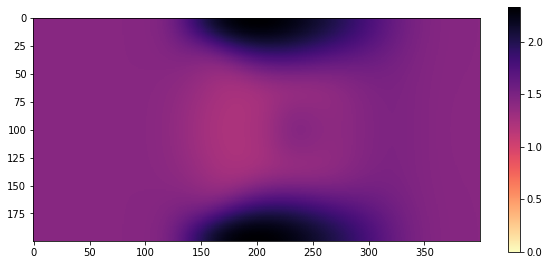

In [36]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
fig.set_size_inches(10,5)

frame = 0

rhop=prof_rho[-1].copy()
vmax=np.max(rhop)
img = plt.imshow(prof_rho[0], cmap='magma_r', vmin=0, vmax=vmax)

plt.colorbar(shrink=0.9)


def update(*args):
    global frame
    #print(frame)

    img.set_array(prof_rho[frame])

    frame += 1

    return img,

ani = animation.FuncAnimation(fig, update, 1000)
writer = animation.FFMpegWriter(fps=20)
ani.save('asympt_prof.avi', writer=writer) 

## $m_l, \rho_l$ 

In [356]:
def outputLastProfile(rho0, mx0, my0, tmax, dt, lx, ly, ds, v, beta, D):
    vec_t=np.arange(0,tmax,dt)
    X=np.concatenate([rho0, mx0, my0])
    
    for t in vec_t:
        X0=X.copy()

        X=update_X_vect(X0, v, D, beta, dt, ds, ly)

        rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    return(rho, mx, my)

In [391]:
lx=500
ly=20

rhof=np.ones((ly,lx))
mxf=np.zeros((ly,lx))
myf=np.zeros((ly,lx))

r0=1.
rhof[:, :]+=r0*np.exp(-((np.arange(lx)-(lx/2))/50)**2)
mxf[:, :]=np.sqrt(2*rhof*rhof*(beta-1-1/rhof)/(beta*beta*(1-beta/3)))
X=np.concatenate([rhof, mxf, myf])

last_rho=[]
last_mx=[]
last_my=[]


list_D_2=np.linspace(0.5, 4.5, 20)
for D in list_D_2:
    print(D)
    rhof, mxf, myf = outputLastProfile(rho0=rhof, mx0=mxf, my0=myf, tmax=5000, dt=1e-1, lx=lx, ly=ly, ds=1, 
                             v=1, beta=2, D=D)
    last_rho.append(rhof)
    last_mx.append(mxf)
    last_my.append(myf)

0.5
0.7105263157894737
0.9210526315789473
1.131578947368421
1.3421052631578947
1.5526315789473684
1.763157894736842
1.9736842105263157
2.1842105263157894
2.394736842105263
2.6052631578947367
2.8157894736842106
3.026315789473684
3.2368421052631575
3.4473684210526314
3.6578947368421053
3.8684210526315788
4.078947368421052
4.289473684210526
4.5


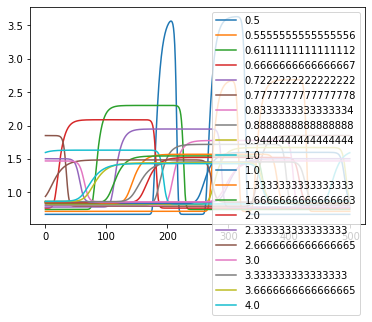

In [392]:
for nD in range(len(last_rho)):
    plt.plot(np.mean(last_rho[nD], axis=0), label=list_D[nD])
    plt.legend()

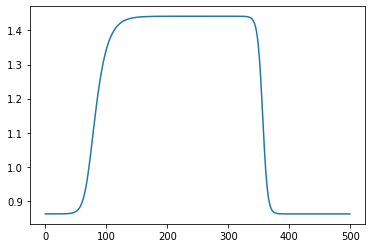

In [393]:
plt.plot(np.mean(last_rho[-2], axis=0), label=list_D[-1])


In [394]:
rhol_vec=[np.max(np.mean(last_rho[nD], axis=0)) for nD in range(len(last_rho))]
mxl_vec=[np.max(np.mean(last_mx[nD], axis=0)) for nD in range(len(last_rho))]
myl_vec=[np.max(np.mean(last_my[nD], axis=0)) for nD in range(len(last_rho))]

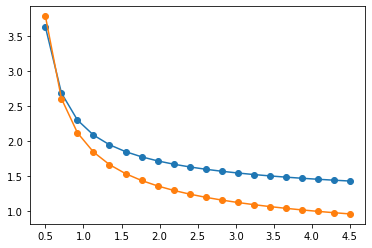

In [395]:
plt.plot(list_D_2, rhol_vec,'o-')
plt.plot(list_D_2, mxl_vec,'o-')
#plt.plot(list_D_2, myl_vec,'o')

In [396]:
#list_D_2=np.linspace(0.5, 4.5, 20)
#np.savetxt('mxl_vec_m.dat', mxl_vec)
#np.savetxt('rho_vec_m.dat', rhol_vec)

Text(0, 0.5, '$D$')

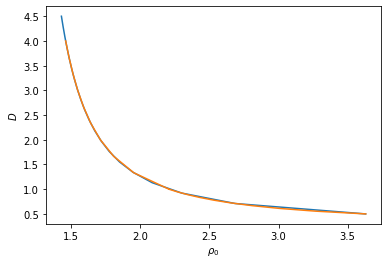

In [556]:
plt.plot(rhol_vec, list_D_2, '-')
plt.plot(rhol, list_D, '-')

plt.xlabel(r'$\rho_0$')
plt.ylabel(r'$D$')
#plt.plot(list_D, ml, 'o-')

## Interpolation between $\vec{m}$ and $m$

In [15]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [41]:
def update_X_vect_interp(X, v, D, beta, dt, dx, ly, alpha):
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]   
    
    drho = rho\
    - alpha*v*(dt/dx)*(np.roll(my, axis=0,shift=-1)-np.roll(my, axis=0,shift=1))/2\
    - v*(dt/dx)*(np.roll(mx, axis=1,shift=-1)-np.roll(mx, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    norm_m=np.sqrt(mx*mx+my*my)
    
    dmx = mx\
    - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(mx, L, mode='same', boundary='wrap')\
    + 2*dt*(beta-1-1/rho)*mx \
    - dt*beta*beta*(1-beta/3)*mx*norm_m*norm_m/(rho*rho) 
       
    dmy = my \
    - alpha*v*(dt/dx)*(np.roll(rho, axis=0,shift=-1)-np.roll(rho, axis=0,shift=1))/2 \
    + D*(dt/(dx*dx))*convolve2d(my, L, mode='same', boundary='wrap') \
    + 2*dt*(beta-1-1/rho)*my\
    - dt*beta*beta*(1-beta/3)*my*norm_m*norm_m/(rho*rho) 

    return(np.concatenate([drho, dmx, dmy]))

In [42]:
mxl_vec=np.loadtxt('mxl_vec_m.dat')
rhol_vec=np.loadtxt('rho_vec_m.dat')

In [61]:
lx=400
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [136]:
# INITIAL CONDITION : fluctuation in liq phase
nD=5
D=list_D[nD]
print('D =', D)
alpha=0.3

rho=rhol_vec[nD]*np.ones((ly,lx))
mx=mxl_vec[nD]*np.ones((ly,lx))
#my=myl_vec[nD]*np.ones((ly,lx))
my=np.zeros((ly,lx))


h0=2000
mx-=3*mx[0,0]*gaussianFluctH(lx, ly, h0)
#my-=3*my[0,0]*gaussianFluctH(lx, ly, h0)

rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, mx, my])

D = 0.7777777777777778


In [137]:
prof_rho=[]
prof_mx=[]
prof_my=[]

rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]
prof_rho.append(rho.copy())
prof_mx.append(mx.copy())
prof_my.append(my.copy())


for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect_interp(X0, v, D, beta, dt, ds, ly, alpha)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [144]:
# LAUNCH TO RESUME SIMU
for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect_interp(X0, v, D, beta, dt, ds, ly, alpha)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [152]:
# LAUNCH TO RESUME SIMU
t_long=1000
vec_t_long=np.arange(0,t_long,dt)

for t in vec_t_long:
    X0=X.copy()
    
    X=update_X_vect_interp(X0, v, D, beta, dt, ds, ly, alpha)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [ ]:
ax2 = fig.add_subplot(122, polar=True)

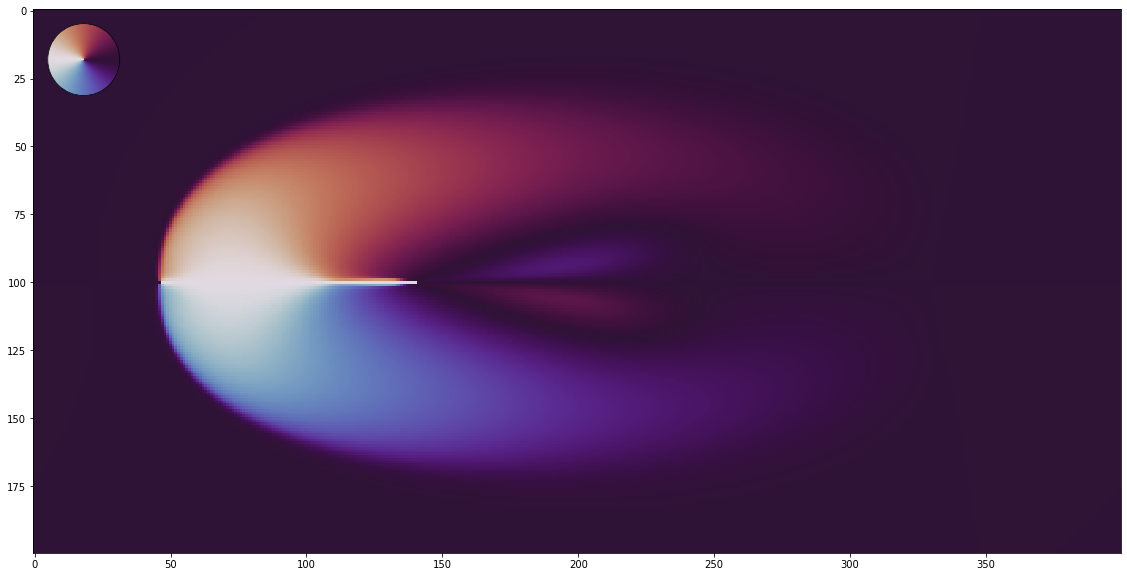

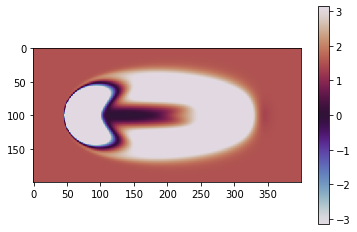

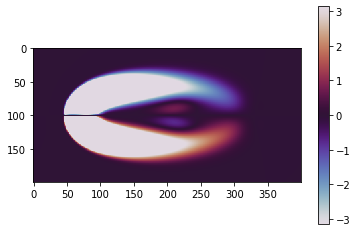

In [322]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight')
ax2.set_yticks([])
ax2.set_xticks([])

t=1000
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
ax.imshow(np.arctan2(myp,mxp), cmap='twilight_r', vmin=-np.pi, vmax=np.pi)
plt.show()

plt.imshow(mxp, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()
plt.imshow(myp, cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [288]:
np.arctan2(prof_my[0],prof_mx[0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

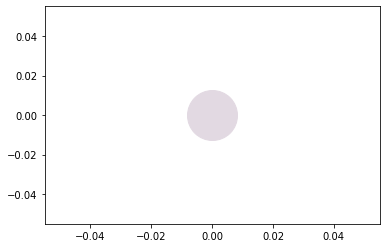

In [294]:
plt.plot(0,0, 'o', markersize=50, color=plt.get_cmap('twilight')(0.))

In [148]:
np.array(prof_mx).shape

(8001, 200, 400)

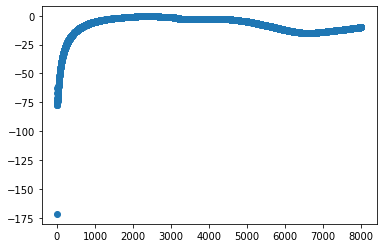

In [149]:
plt.plot(np.mean(np.array(prof_mx)[:,100,:], 1), 'o')

In [131]:
prof_rho[t].shape

(200, 400)

(0, 20)

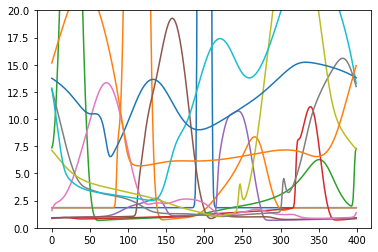

In [150]:
for t in np.arange(0, 8*np.int64(tmax/dt),700):
    plt.plot(prof_rho[t][100,:])
plt.ylim(0,20)

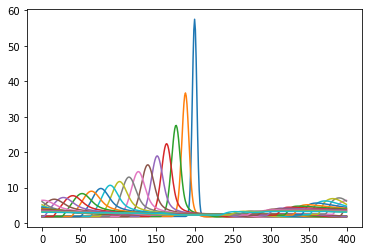

In [133]:
for t in np.arange(0, 3*np.int64(tmax/dt),100):
    plt.plot(np.mean(prof_rho[t],0))

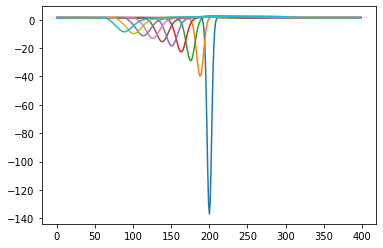

In [134]:
for t in np.arange(0, np.int64(tmax/dt),100):
    plt.plot(np.mean(prof_mx[t],0))

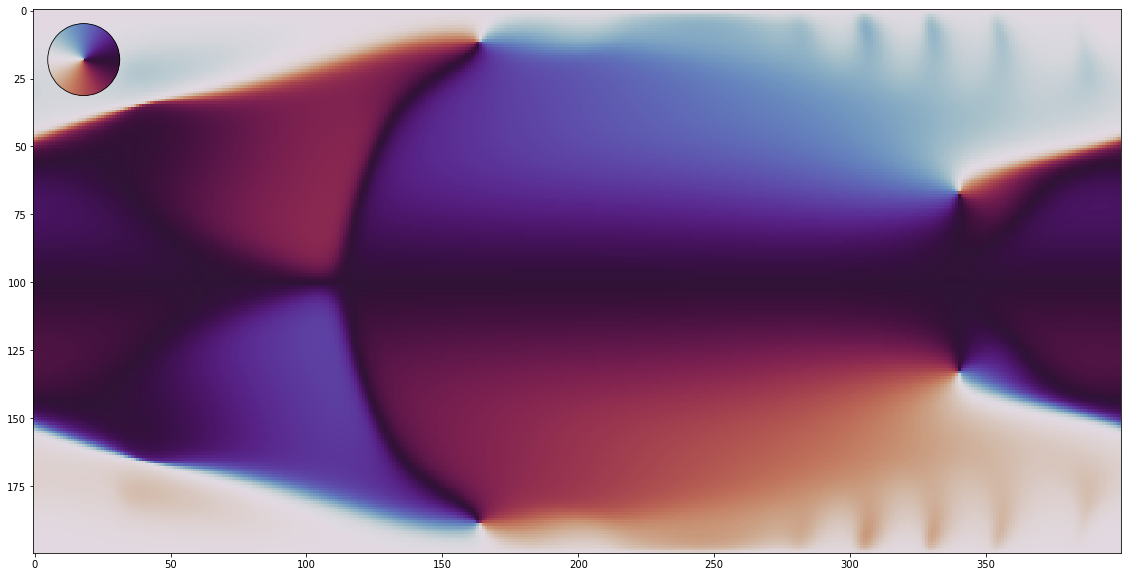

In [284]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

frame = 0

#rhop=prof_rho[-1].copy()
#vmax=np.max(rhop)
#plt.imshow(prof_rho[0], cmap='magma_r', vmin=0, vmax=vmax)
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

mxp=prof_mx[0].copy()
myp=prof_my[0].copy()
img = ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)



def update(*args):
    global frame
    #print(frame)

    #img.set_array(prof_rho[frame])
    img.set_array(np.arctan2(prof_my[frame],prof_mx[frame]))

    frame += 8

    return img,

ani = animation.FuncAnimation(fig, update, 1000)
writer = animation.FFMpegWriter(fps=20)
ani.save('asympt_prof_alpha0.3_h2000.avi', writer=writer) 